<a id="top"></a>
# Correcting for Helium Line Emission Background in IR Exposures using the "Flatten-Ramp" Technique
<hr>
## Learning Goals
This notebook shows how to identify IR exposures with time-variable Helium (1.083 micron) line emission background, and how to correct for it using the "flatten-ramp" technique. This method can be used to correct images affected by a sky background that does not vary across the field of view.  For recommendations on correcting for spatially variable background due to scattered light, see the [IR IMA Visualization Notebook](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/WFC3/ir_ima_visualization) (O'Connor 2023).

By the end of this tutorial, you will be able to: 

- Identify exposures with time-variable background.
- Compute and analyze statistics for each read of an IMA file. 
- Reprocess a single exposure without cosmic ray corrections through `calwf3`.
- Correct for time-variable background by subtracting the median background per read and rerunning the ramp-fitting step with `calwf3` turned back on.

## Table of Contents

[Introduction](#intro) <br>

[1. Imports](#import) <br>

[2. Download the Data](#downloaddata) <br>

[3. Identifying Exposures with Time Variable Background](#3) <br>
- [3.1 Displaying the Images](#3.1) <br>
- [3.2 Plotting a Histogram of the Sky Background](#3.2) <br>
- [3.3 Inspecting the IR Ramps](#3.3) <br>

[4. Reprocessing a Single Exposure for Time Variable Background](#4.0)<br>
- [4.1 Query CRDS for best reference files](#4.1)<br>
- [4.2 Recalibrating affected data with 'ramp fitting' step turned off in `calwf3`](#4.2) <br>
- [4.3 Remove Median Background per read from resulting IMA](#4.3) <br>
- [4.4 Rerun `calwf3` on the corrected IMA with 'ramp fitting' turned back on](#4.4)

[5. Comparing Original and Corrected FLT Products](#5)
- [5.1 Displaying the Images](#5.1) <br>
- [5.2 Plotting a Histogram of the Sky Background](#5.2) <br>
- [5.3 Inspecting the IR Ramps](#5.3) <br>
- [5.4 Comparing the Background Noise](#5.4) <br>
- [5.5 Morphology](#5.5) <br>

[6. Conclusion](#conclusions) <br>

[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction <a id="intro"></a>

Helium I emission from the Earth's atmosphere may affect exposures taken in the F105W and F110W filters. Affected  reads are typically taken closest in time to when the spacecraft leaves the Earth's shadow and enters the illuminated atmosphere. The 1.083 micron emission produces a flat background signal which is added to the total background in affected reads. The strength of the emission background signal depends on the observed path-length through the illuminated atmosphere, and in some cases is strong enough to compromise the ramp fitting calibration performed by `calwf3`, which is initially designed to flag and remove cosmic rays and saturated reads as they come through. This results in the FLT image to have much larger noise and a non-gaussian sky background.

This notebook demonstrates multiple ways on how to identify exposures with time variable background, and how to correct for these additional noise through the usage of the "flatten-ramp" technique described in [WFC3 ISR 2016-16](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-16.pdf). This technique turns off ramp fitting in `calwf3` and treats the IR detector like a CCD detector to avoid flagging and removing cosmic rays. We then remove the median background per read and add back in the full exposure countrate to preserve pixel statistics and then rerun `calwf3` on the resulting IMA file with ramp fitting turned back on. This results in a cosmic-ray and time variable background corrected FLT file.

An alternate approach is the 'last-minus-first' technique described in the following [CALWF3 notebook](https://github.com/spacetelescope/WFC3Library/tree/master/notebooks/calwf3_recalibration). This turns off the ramp fitting step in `calwf3` (CRCORR=omit), treating the IR detector like a CCD accumulating charge and read out only at the end of the exposure. In this approach, the observed count rate is determined by simply subtracting the first read from the last of the detector and dividing by the time elapsed between the two reads. A disadvantage of this method is that this leaves cosmic-rays in the calibrated FLT frames which must be rejected with other software, such as AstroDrizzle.  However, this approach may be used for extended targets and crowded stellar fields where it may be difficult to detangle the sky background from the light from astronomical sources using simple median statistics.

Time variable background also affects IR grisms. However, the method in this notebook should not be used to correct G102 and G141 observations, as they are affected by a combination of Helium I and Zodiacal background. Details on correcting grism data is provided in [WFC3 ISR 2017-05: Variable He I emission in grism data](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-05.pdf).




## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

Imports:
- *os* for setting environment variables


- *glob* for filtering out list of files


- *shutil* for managing directories


- *numpy* for array functionality


- *pandas* for organizing data into a dataframe


- *matplotlib.pyplot* for plotting data and images


- *astropy.io fits* for opening FITS files 


- *astroquery.mast Observations* for downloading data from MAST


- *ccdproc ImageFileCollection* for building the association. 


- *wfc3tools* for computing statistics on IMA files.

In [1]:
import os
import glob
import shutil

from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import wfc3tools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Download the Data <a id="downloaddata"></a>

First, we query MAST for the necessary data and download them to the current directory.

We obtain WFC3/IR observations from Visit BF of CANDELS program [12242](https://www.stsci.edu/hst-program-info/program/?program=12442). ASN, RAW, IMA, and FLT files are requested.

**Warning**: This cell may take a few minutes to complete depending on computer speed and storage.

In [2]:
data_list = Observations.query_criteria(obs_id='IBOHBF*')
Observations.download_products(data_list['obsid'], project='CALWF3', mrp_only=False, download_dir='./data',
                               productSubGroupDescription=['ASN', 'RAW', 'IMA', 'FLT'])

science_files = glob.glob("data/mastDownload/HST/*/*fits")
for im in science_files:
    root = os.path.basename(im)
    new_path = os.path.join("./", root)
    os.rename(im, new_path)

shutil.rmtree("data/")

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Visit BF association file *ibohbf040_asn.fits* contains a single visit over 3 orbits with 6 consecutive exposures in F105W dithered by a small fraction of the field of view. Each orbit consists of 2 back-to-back 1600 second exposure followed by the Earth occulation.

In [3]:
# printing observation conditions for visits used
collec = ImageFileCollection('./',
                             keywords=["asn_id", "targname", "filter",
                                       "samp_seq", "nsamp", "exptime",
                                       "postarg1", "postarg2", "date-obs",
                                       "time-obs"],
                             glob_include="*flt.fits", ext=0)
out_table = collec.summary
out_table

file,asn_id,targname,filter,samp_seq,nsamp,exptime,postarg1,postarg2,date-obs,time-obs
str18,str9,str12,str5,str7,int64,float64,float64,float64,str10,str8
ibohbfb7q_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,-0.237,-0.212,2013-01-06,18:23:01
ibohbfb9q_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.305,-0.03,2013-01-06,18:50:42
ibohbfbdq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.102,0.273,2013-01-06,19:18:23
ibohbfbgq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,-0.44,0.091,2013-01-06,19:48:08
ibohbfbkq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.237,0.212,2013-01-06,20:15:49
ibohbfbpq_flt.fits,IBOHBF040,GOODN-N1-VBF,F105W,STEP200,16,1599.23291,0.779,0.394,2013-01-06,20:43:30


## 3. Identifying Exposures with Time Variable Background <a id="3"></a>

There are three ways to identify exposures with poor ramp fitting due to time variable background:
1. Display the FLT images and look for unusually large noise.


2. Plot a histogram of the FLT sky background and look for a non-gaussian distribution.


3. Look for non-linearity in the median background of each ramp in the IMA file.


There are several exposures in this visit that are impacted by time variable background. For conciseness, this notebook will focus only on the first two exposures in the visit. Both exposures make up a single orbit. The first exposure *ibohbfb7q* is not impacted, while the second exposure *ibohbfb9q* suffers from additional time variable background.

### 3.1 Displaying the Images <a id="3.1"></a>
An FLT exposure with a poor ramp fit will have a noisier background than a FLT exposure with a good ramp fitting.

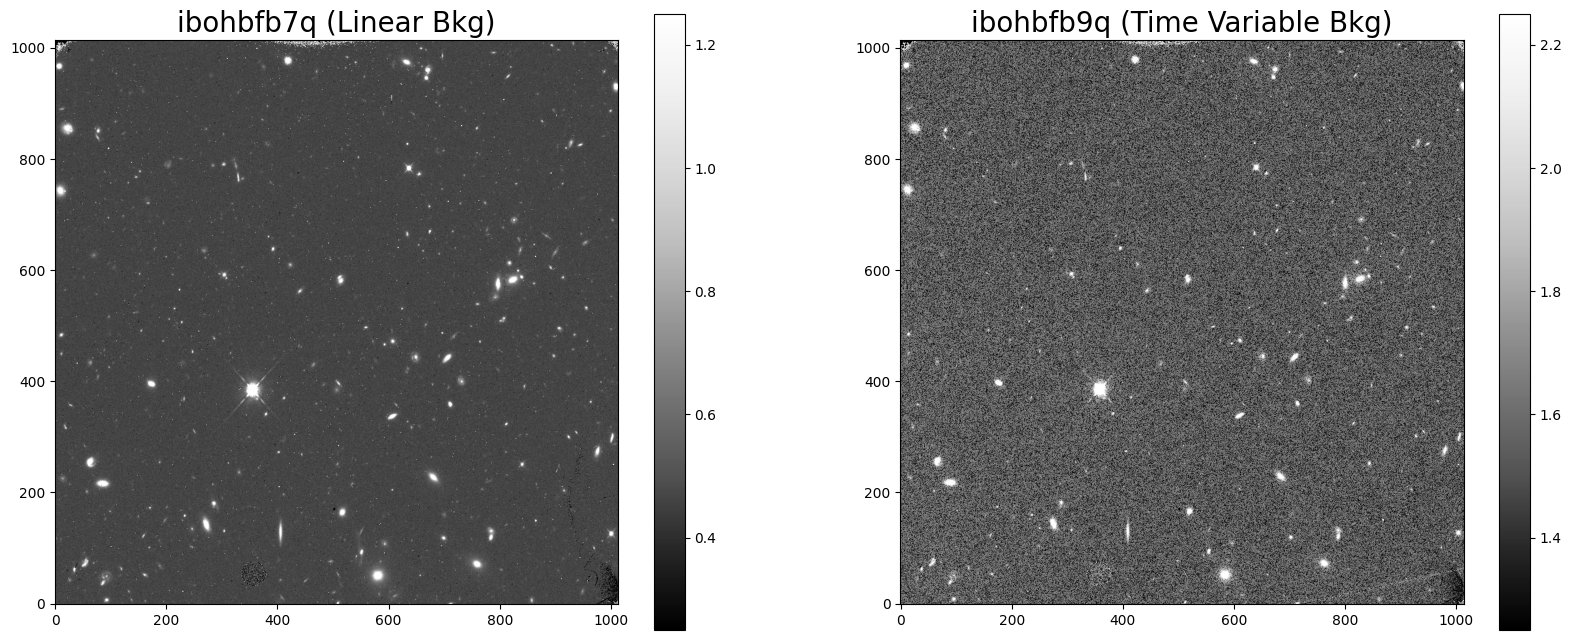

In [4]:
flt1 = fits.getdata('ibohbfb7q_flt.fits', ext=1)
flt2 = fits.getdata('ibohbfb9q_flt.fits', ext=1)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

A = ax1.imshow(flt1, vmin=0.25, vmax=1.25, cmap='Greys_r', origin='lower')
B = ax2.imshow(flt2, vmin=1.25, vmax=2.25, cmap='Greys_r', origin='lower')
ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=20)
ax2.set_title('ibohbfb9q (Time Variable Bkg)', fontsize=20)
fig.colorbar(A, ax=ax1)
fig.colorbar(B, ax=ax2)

### 3.2 Plotting a Histogram of the Background <a id="3.2"></a>

Impacted FLT exposures will typically have a non-gaussian background, often consisting of a double peak and a large sigma.

Text(0.5, 1.0, 'ibohbfb9q (Time Variable Bkg)')

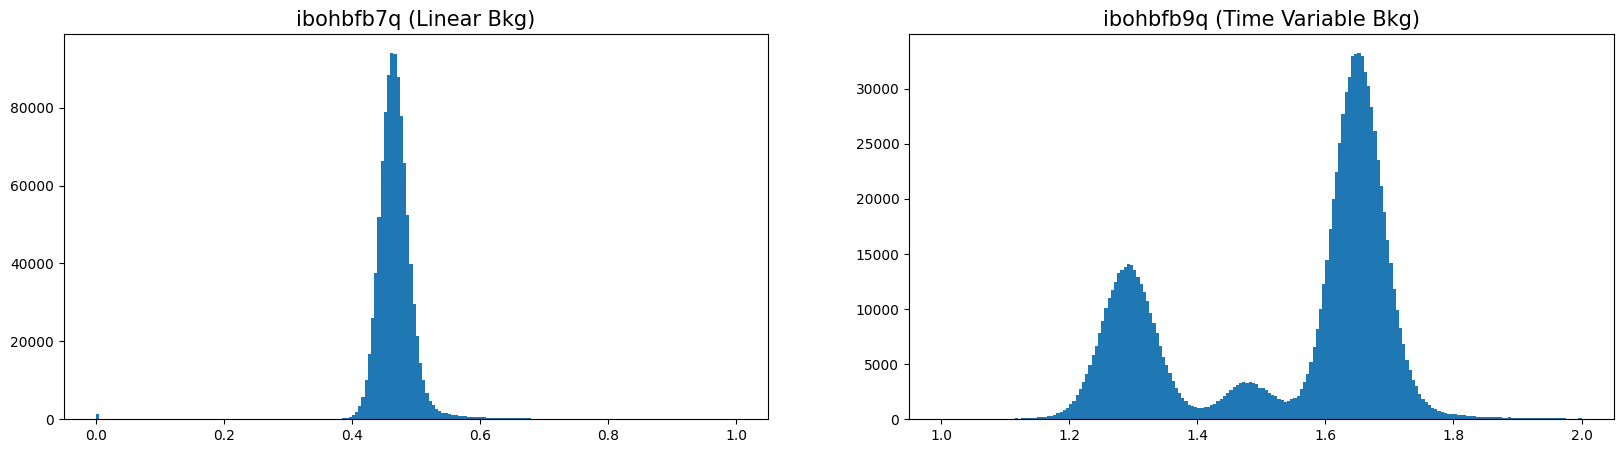

In [5]:
flt1f = flt1.flatten()
flt2f = flt2.flatten()

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

n, bins, patches = ax1.hist(flt1f, bins=200, range=(0, 1))
n, bins, patches = ax2.hist(flt2f, bins=200, range=(1, 2))

ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=15)
ax2.set_title('ibohbfb9q (Time Variable Bkg)', fontsize=15)

### 3.3 Inspecting the IR Ramps <a id="3.3"></a>
We use the *pstat* task in wfc3tools to compute statistics up the stack of each IMA image. We use the midpoint of each ramp as a good representation of the total background, due to the target being mostly blank sky.

#### Plotting Count vs. Time

The median signal in the first image accumulates linearly, while the affected image's median signal accumulates non-linearly over the exposure.

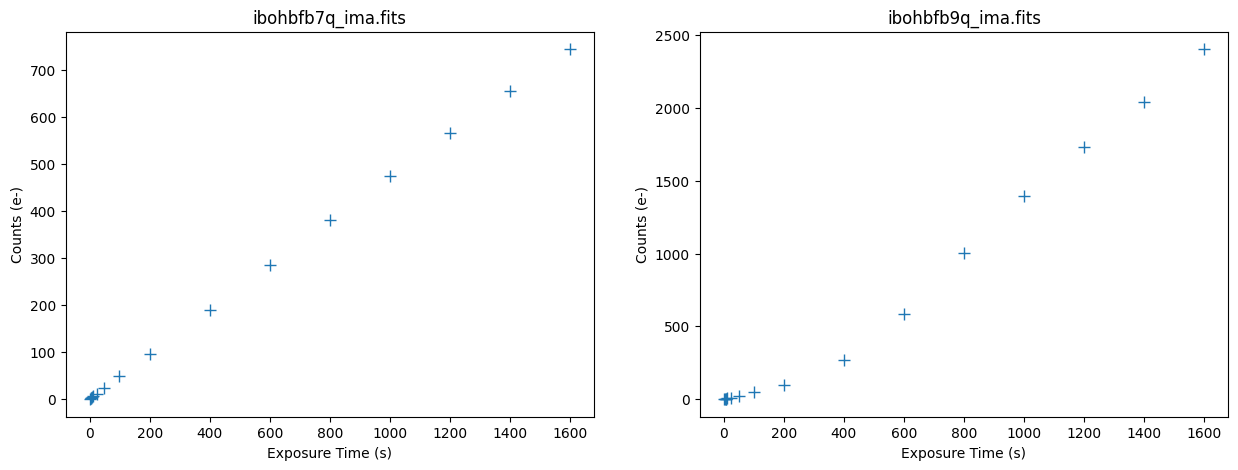

In [6]:
imafiles = ('ibohbfb7q_ima.fits', 'ibohbfb9q_ima.fits')
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
fig.set_dpi(100)

for i, ima in enumerate(imafiles):
    time, counts = wfc3tools.pstat(ima, stat='midpt', units='counts', plot=False)
    axarr[i].plot(time, counts, '+', markersize=8)
    axarr[i].set_title(ima)
    axarr[i].set_xlabel('Exposure Time (s)')
    axarr[i].set_ylabel('Counts (e-)')

#### Plotting Count Rate versus Time
The median count rate of the first image is relatively flat at ~0.5 electrons/sec, which is primarily zodiacal light. There is a small excess signal seen in the first few ramps, but this is unlikely to impact `calwf3`'s ramp fitting step. The median count rate of the affected image varies from ~0.5 electrons/sec at the beginning of the exposure to ~1.5 electrons/sec at the end of the exposure, nearly a change by a factor of ~3. Inspecting the ramp of *ibohbfb9q_ima* reveals that the background signal due to the helium line emission increased rapidly in the middle of the exposure then flattens at the end.

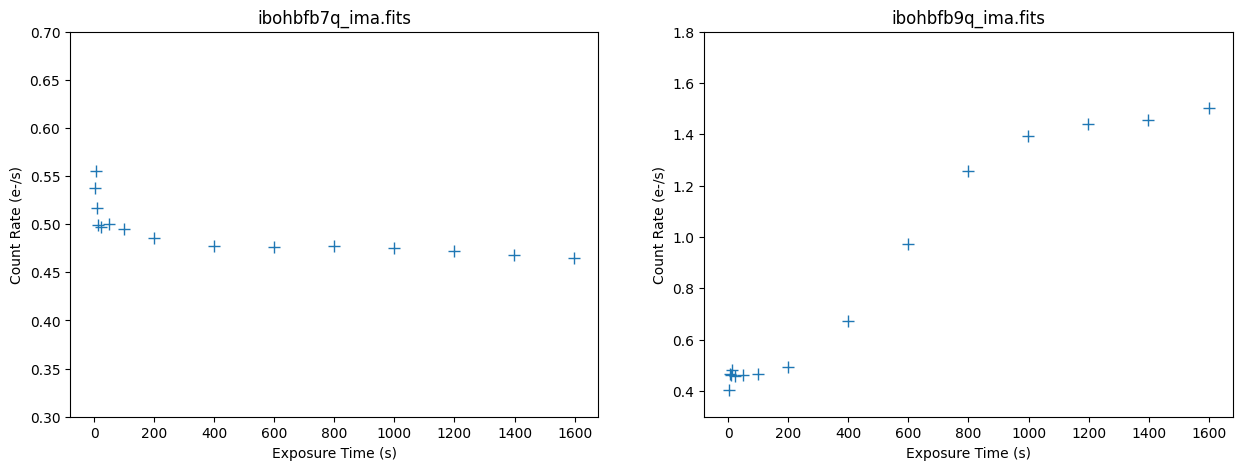

In [7]:
imafiles = ('ibohbfb7q_ima.fits', 'ibohbfb9q_ima.fits')
ylim = [(0.3, 0.7), (0.3, 1.8)]
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
fig.set_dpi(100)

for i, ima in enumerate(imafiles):
    time, counts = wfc3tools.pstat(ima, stat='midpt', units='rate', plot=False)
    axarr[i].plot(time, counts, '+', markersize=8)
    axarr[i].set_title(ima)
    axarr[i].set_xlabel('Exposure Time (s)')
    axarr[i].set_ylabel('Count Rate (e-/s)')
    axarr[i].set_ylim(ylim[i])

## 4. Reprocessing a Single Exposure for Time Variable Background <a id="4.0"></a>

Now that we have identified signs of time variable background, the next step is to reprocess the data to improve the quality of the FLT data product.
In brief, the steps are as follows:

1. Query CRDS for best reference files.


2. Recalibrate affected raw data with 'ramp fitting' step turned off using `calwf3`.


3. Remove the median background per read from the resulting IMA file.


4. Rerun `calwf3` on the corrected IMA, with 'ramp fitting' turned back on.

### 4.1 Query CRDS for Best Reference Files <a id="4.1"></a>

We first set environment variables for several calibration tasks.

We point to subdirectory `crds_cache/` using the IREF environment variable. The IREF variable is used for WFC3 reference files. 

In [8]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

We now download the "bestrefs" for these RAW files.

The code block belows queries CRDS for the current best reference files for the dataset and updates the header keyword to point to these new files. The python package `os` is used to run terminal commands.

**Warning**: This cell may take a few minutes to complete depending on computer speed and storage.

In [9]:
raw_files = glob.glob('*_raw.fits')

for file in raw_files:
    !crds bestrefs --files $file --sync-references=1 --update-bestrefs;

CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfb9q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbdq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfb7q_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbgq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbpq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ibohbfbkq_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


### 4.2 Recalibrating affected data with 'ramp fitting' step turned off in `calwf3` <a id="4.2"></a>

Next, we run `calwf3` on the affected file *ibohbfb9q* with CRCORR=OMIT to perform all steps except the ramp fitting.

In [10]:
# Renaming files
os.rename('ibohbfb9q_ima.fits', 'ibohbfb9q_ima_orig.fits')
os.rename('ibohbfb9q_flt.fits', 'ibohbfb9q_flt_orig.fits')

# Updating the raw file
raw_file = 'ibohbfb9q_raw.fits'
with fits.open(raw_file, mode='update') as raw:
    raw[0].header['CRCORR'] = 'OMIT'

# Running wfc3tools.calwf3
wfc3tools.calwf3(raw_file)

# Renaming the processed flt file
os.rename('ibohbfb9q_flt.fits', 'ibohbfb9q_flt_norampfit.fits')

git tag: 0090c701-dirty

git branch: HEAD

HEAD @: 0090c701d894003cfc690e9f8d5fde81e6939090





CALBEG*** CALWF3 -- Version 3.7.2 (Apr-15-2024) ***

Begin    19-Nov-2025 18:51:30 UTC





Input    ibohbfb9q_raw.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ibohbfb9q_raw.fits...

Read in Primary header from ibohbfb9q_raw.fits...

Revising existing trailer file `ibohbfb9q.tra'.





CALBEG*** WF3IR -- Version 3.7.2 (Apr-15-2024) ***

Begin    19-Nov-2025 18:51:30 UTC

Input    ibohbfb9q_raw.fits

Output   ibohbfb9q_flt.fits

Trying to open ibohbfb9q_raw.fits...

Read in Primary header from ibohbfb9q_raw.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfb9q_raw.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,19.9,20.1

ZSIGCORR detected 1285 saturated pixels in 0th read

ZSIGCORR detected 1349 saturated pixels in 1st read

ZSIGCORR COMPLETE

BLEVCORR PERFORM

OSCNTAB  iref$q911321mi_osc.fits

OSCNTAB  PEDIGREE=GROUND

OSCNTAB  DESCRIP =Initial values for ground test data processing

BLEVCORR COMPLETE

ZOFFCORR PERFORM

ZOFFCORR COMPLETE

NOISCORR PERFORM

Uncertainty array initialized.

NOISCORR COMPLETE

NLINCORR PERFORM

NLINFILE iref$9au15283i_lin.fits

NLINFILE PEDIGREE=INFLIGHT 29/03/2011 25/11/2012

NLINFILE DESCRIP =Non-linearity, pixel-based correction from WFC3 on-orbit frames

NLINCORR detected 1285 saturated pixels in imset 16



NLINCORR detected 1354 saturated pixels in imset 15

NLINCORR detected 1381 saturated pixels in imset 14

NLINCORR detected 1388 saturated pixels in imset 13



NLINCORR detected 1395 saturated pixels in imset 12

NLINCORR detected 1413 saturated pixels in imset 11

NLINCORR detected 1433 saturated pixels in imset 10

NLINCORR detected 1466 saturated pixels in imset 9



NLINCORR detected 1502 saturated pixels in imset 8

NLINCORR detected 1561 saturated pixels in imset 7

NLINCORR detected 1671 saturated pixels in imset 6

NLINCORR detected 2295 saturated pixels in imset 5



NLINCORR detected 2916 saturated pixels in imset 4

NLINCORR detected 3206 saturated pixels in imset 3

NLINCORR detected 3328 saturated pixels in imset 2

NLINCORR detected 3400 saturated pixels in imset 1

NLINCORR COMPLETE

DARKCORR PERFORM

DARKFILE iref$35620245i_drk.fits

DARKFILE PEDIGREE=INFLIGHT 20/09/2009 15/11/2016

DARKFILE DESCRIP =Dark Created from 154 frames spanning cycles 17 to 24--------------



DARKCORR using dark imset 16 for imset 16 with exptime=       0

DARKCORR using dark imset 15 for imset 15 with exptime= 2.93229

DARKCORR using dark imset 14 for imset 14 with exptime= 5.86458



DARKCORR using dark imset 13 for imset 13 with exptime= 8.79687

DARKCORR using dark imset 12 for imset 12 with exptime= 11.7292



DARKCORR using dark imset 11 for imset 11 with exptime= 24.2297

DARKCORR using dark imset 10 for imset 10 with exptime= 49.2302



DARKCORR using dark imset  9 for imset  9 with exptime= 99.2306

DARKCORR using dark imset  8 for imset  8 with exptime= 199.231



DARKCORR using dark imset  7 for imset  7 with exptime= 399.231

DARKCORR using dark imset  6 for imset  6 with exptime= 599.232



DARKCORR using dark imset  5 for imset  5 with exptime= 799.232

DARKCORR using dark imset  4 for imset  4 with exptime= 999.232



DARKCORR using dark imset  3 for imset  3 with exptime= 1199.23

DARKCORR using dark imset  2 for imset  2 with exptime= 1399.23



DARKCORR using dark imset  1 for imset  1 with exptime= 1599.23

DARKCORR COMPLETE

PHOTCORR PERFORM

IMPHTTAB iref$8ch15233i_imp.fits

IMPHTTAB PEDIGREE=INFLIGHT 08/05/2009 01/09/2024

IMPHTTAB DESCRIP =Time-dependent image photometry reference table (IMPHTTAB)---------

Found parameterized variable 1.

NUMPAR=1, N=1

Allocated 1 parnames

Adding parameter mjd#56298.7852 as parnames[0]

==> Value of PHOTFLAM = 3.0608668e-20

==> Value of PHOTPLAM = 10551.047

==> Value of PHOTBW = 845.61804

PHOTCORR COMPLETE

UNITCORR PERFORM

UNITCORR COMPLETE

CRCORR   OMIT

FLATCORR PERFORM

PFLTFILE iref$4ac19225i_pfl.fits

PFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

PFLTFILE DESCRIP =Sky Flat from Combined In-flight observations between 2009 and 2019

DFLTFILE iref$4ac18263i_dfl.fits

DFLTFILE PEDIGREE=INFLIGHT 31/07/2009 05/12/2019

DFLTFILE DESCRIP =Delta-Flat for IR Blobs by Date of Appearance from Sky Flat Dataset



FLATCORR COMPLETE

Writing calibrated readouts to ibohbfb9q_ima.fits



Writing final image to ibohbfb9q_flt.fits

 with trimx = 5,5, trimy = 5,5





End      19-Nov-2025 18:51:34 UTC

*** WF3IR complete ***





End      19-Nov-2025 18:51:34 UTC

*** CALWF3 complete ***

CALWF3 completion for ibohbfb9q_raw.fits



### 4.3 Remove Median Background per read from resulting IMA <a id="4.3"></a>
Next, the median background level from each read of the resulting IMA is subtracted from the read, and is later added back to the full exposure to preserve pixel statistics.

You can define a specific subregion for stats, as well as add additional lower or upper thresholds to fine-tune the calculation of the sky median value. Here, we use the median value of the entire image minus the 5 pixel wide overscan regions with no sigma clipping.

This technique works best for relatively sparse fields, where the median value of the ramp is equivalent to the sky level.

ibohbfb9q_raw.fits, [SCI, 1], median_bkg: 1.50
ibohbfb9q_raw.fits, [SCI, 2], median_bkg: 1.46
ibohbfb9q_raw.fits, [SCI, 3], median_bkg: 1.44
ibohbfb9q_raw.fits, [SCI, 4], median_bkg: 1.40
ibohbfb9q_raw.fits, [SCI, 5], median_bkg: 1.26
ibohbfb9q_raw.fits, [SCI, 6], median_bkg: 0.97
ibohbfb9q_raw.fits, [SCI, 7], median_bkg: 0.67
ibohbfb9q_raw.fits, [SCI, 8], median_bkg: 0.49


ibohbfb9q_raw.fits, [SCI, 9], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI, 10], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI, 11], median_bkg: 0.46
ibohbfb9q_raw.fits, [SCI, 12], median_bkg: 0.49


ibohbfb9q_raw.fits, [SCI, 13], median_bkg: 0.47
ibohbfb9q_raw.fits, [SCI, 14], median_bkg: 0.48
ibohbfb9q_raw.fits, [SCI, 15], median_bkg: 0.42


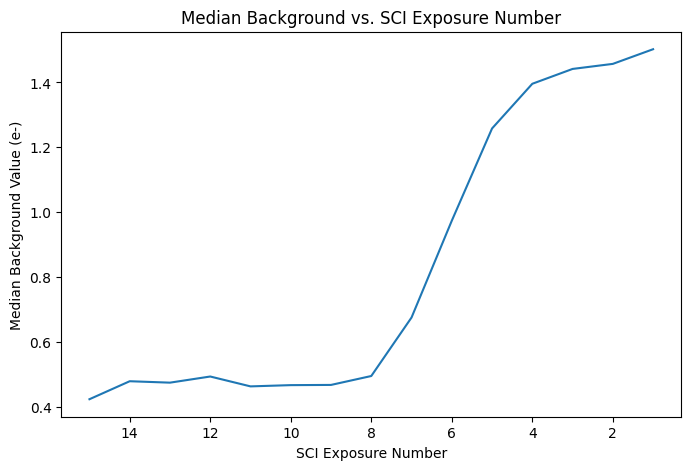

In [11]:
with fits.open(raw_file.replace('raw', 'ima'), mode='update') as ima:
    # You can define a subregion for stats. Here we use the whole image, minus the 5 pixel wide overscan regions
    stats_region = [[5, 1014], [5, 1014]]
    slx = slice(stats_region[0][0], stats_region[0][1])
    sly = slice(stats_region[1][0], stats_region[1][1])

    # Subtract the median countrate from each read and add back the full exposure countrate to preserve pixel statistics
    total_countrate = np.median(ima['SCI', 1].data[sly, slx])
    median = []
    sci_num = []
    for i in range(ima[0].header['NSAMP'] - 1):
        med = np.median(ima['SCI', i + 1].data[sly, slx])
        ima['SCI', i + 1].data += total_countrate - med
        print(f'{raw_file}, [SCI, {i + 1}], median_bkg: {med:.2f}')
        sci_num.append(i + 1)
        median.append(med)

    plt.figure(figsize=(8, 5))
    plt.plot(sci_num, median)
    plt.gca().invert_xaxis()
    plt.title("Median Background vs. SCI Exposure Number")
    plt.xlabel('SCI Exposure Number')
    plt.ylabel('Median Background Value (e-)')
    # Turn back on the ramp fitting for running calwf3 in the next step
    ima[0].header['CRCORR'] = 'PERFORM'

**Note**: [SCI,15] is the first read and [SCI,1] is the last read of the IR image.

From the printed median background values, we can see that the increased background signal occured in the middle and the end of the exposure, just prior to Earth occulation.

### 4.4 Rerun `calwf3` on the corrected IMA, with 'ramp fitting' turned back on <a id="4.4"></a>

We resume `calwf3` on the cleaned IMA with the CRCORR step turned on. This will produce a corrected IMA and FLT image.

In [12]:
wfc3tools.calwf3(raw_file.replace('raw', 'ima'))

# Clean up and rename files
os.remove('ibohbfb9q_ima.fits')
os.rename('ibohbfb9q_ima_ima.fits', 'ibohbfb9q_ima.fits')
os.rename('ibohbfb9q_ima_flt.fits', 'ibohbfb9q_flt.fits')

git tag: 0090c701-dirty

git branch: HEAD

HEAD @: 0090c701d894003cfc690e9f8d5fde81e6939090





CALBEG*** CALWF3 -- Version 3.7.2 (Apr-15-2024) ***

Begin    19-Nov-2025 18:51:34 UTC





Input    ibohbfb9q_ima.fits

loading asn



LoadAsn:  Processing SINGLE exposure

Trying to open ibohbf040_asn.fits...

Read in Primary header from ibohbf040_asn.fits...

Revising existing trailer file `ibohbfb9q_ima.tra'.





CALBEG*** WF3IR -- Version 3.7.2 (Apr-15-2024) ***

Begin    19-Nov-2025 18:51:34 UTC

Input    ibohbfb9q_ima.fits

Output   ibohbfb9q_ima_flt.fits

Trying to open ibohbfb9q_ima.fits...

Read in Primary header from ibohbfb9q_ima.fits...

APERTURE IR-FIX

FILTER   F105W

DETECTOR IR

Reading data from ibohbfb9q_ima.fits ...

CCDTAB   iref$t2c16200i_ccd.fits

CCDTAB   PEDIGREE=Ground

CCDTAB   DESCRIP =Reference data based on Thermal-Vac #3, gain=2.5 results for IR-4

CCDTAB   DESCRIP =Readnoise,gain,saturation from TV3,MEB2 values. ISRs 2008-25,39,50

    readnoise =20.2,19.8,1

57 pixels detected as unstable

CRCORR   COMPLETE

FLATCORR COMPLETE

Writing calibrated readouts to ibohbfb9q_ima_ima.fits



Writing final image to ibohbfb9q_ima_flt.fits

 with trimx = 5,5, trimy = 5,5





End      19-Nov-2025 18:51:36 UTC

*** WF3IR complete ***





End      19-Nov-2025 18:51:36 UTC

*** CALWF3 complete ***

CALWF3 completion for ibohbfb9q_ima.fits



## 5. Comparing Original and Corrected FLT products <a id="5"></a>

Here we compare the original and corrected FLT products of *ibogbfb9q* and the unaffected *ibohbfb7q*.

### 5.1 Displaying the Images <a id="5.1"></a>
Here we see that the corrected FLT image has reduced in visible noise.

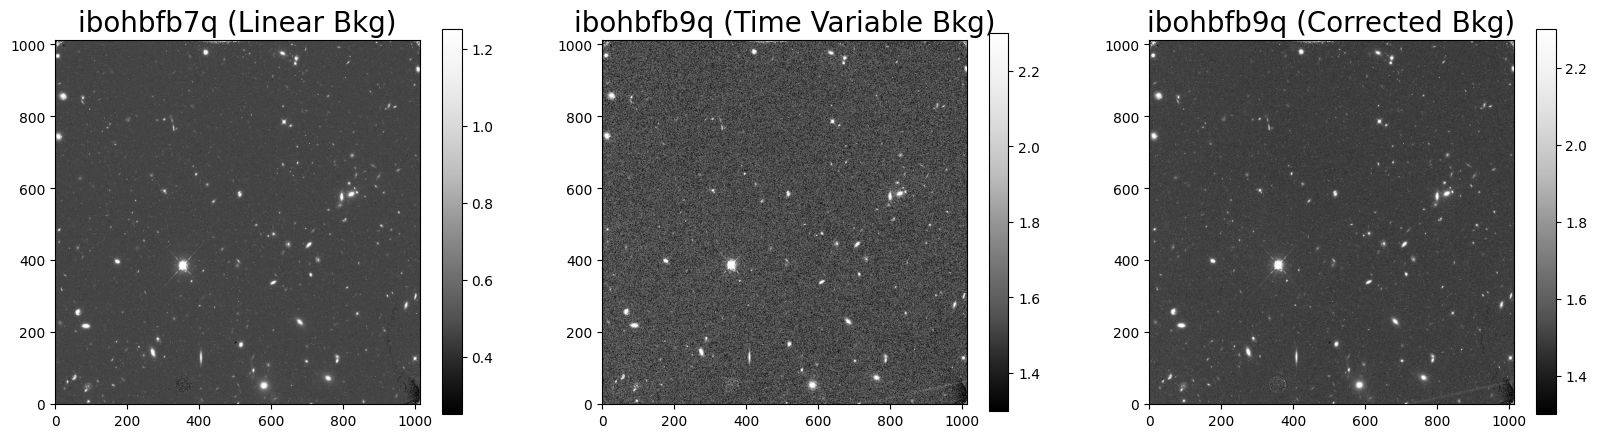

In [13]:
# Display the images
flt1 = fits.getdata('ibohbfb7q_flt.fits', ext=1)
flt2 = fits.getdata('ibohbfb9q_flt_orig.fits', ext=1)
flt2corr = fits.getdata('ibohbfb9q_flt.fits', ext=1)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

A = ax1.imshow(flt1, vmin=0.25, vmax=1.25, cmap='Greys_r', origin='lower')
B = ax2.imshow(flt2, vmin=1.30, vmax=2.30, cmap='Greys_r', origin='lower')
C = ax3.imshow(flt2corr, vmin=1.30, vmax=2.30, cmap='Greys_r', origin='lower')

ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=20)
ax2.set_title('ibohbfb9q (Time Variable Bkg)', fontsize=20)
ax3.set_title('ibohbfb9q (Corrected Bkg)', fontsize=20)

fig.colorbar(A, ax=ax1, shrink=.5)
fig.colorbar(B, ax=ax2, shrink=.49)
fig.colorbar(C, ax=ax3, shrink=.5)

### 5.2 Plotting a Histogram of the Sky Background <a id="5.2"></a>
The corrected FLT product of the affected image now has a gaussian distribution that is expected from the sky background.

Text(0.5, 1.0, 'ibohbfb9q (Corrected)')

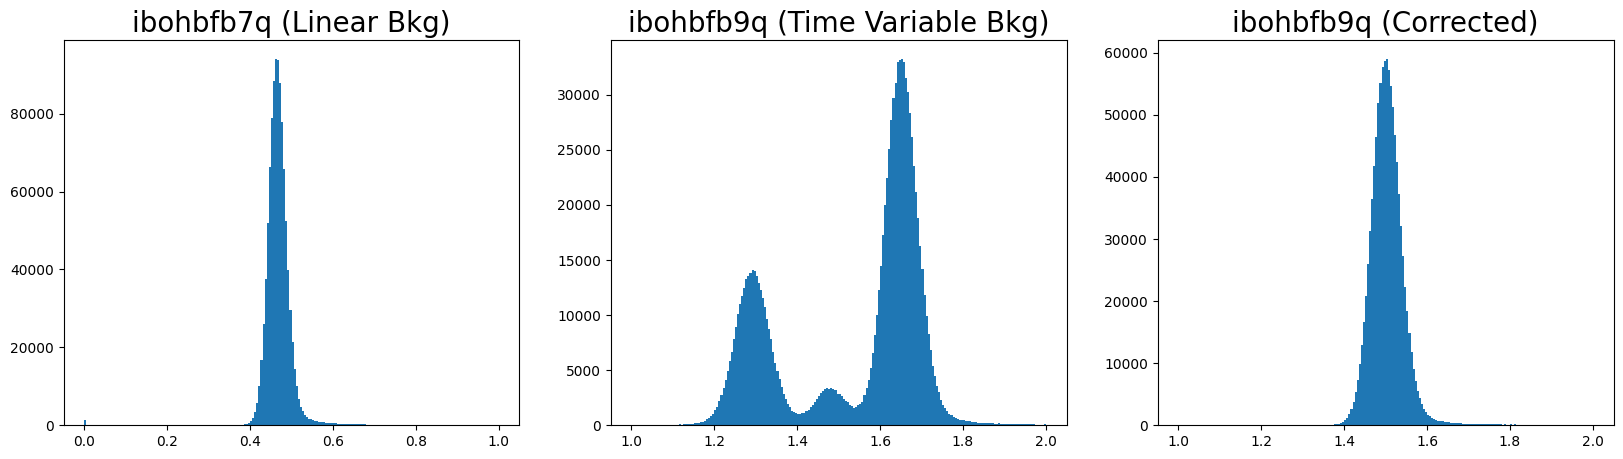

In [14]:
# Plot the histograms
flt1f = flt1.flatten()
flt2f = flt2.flatten()
flt2fcorr = flt2corr.flatten()

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

n, bins, patches = ax1.hist(flt1f, bins=200, range=(0, 1))
n, bins, patches = ax2.hist(flt2f, bins=200, range=(1, 2))
n, bins, patches = ax3.hist(flt2fcorr, bins=200, range=(1, 2))

ax1.set_title('ibohbfb7q (Linear Bkg)', fontsize=20)
ax2.set_title('ibohbfb9q (Time Variable Bkg)', fontsize=20)
ax3.set_title('ibohbfb9q (Corrected)', fontsize=20)

### 5.3 Inspecting the IR Ramps <a id="5.3"></a>

Below we plot the counts versus time for the original and corrected ramp of the affected exposure *ibohbfb9q*. The median background rate is now linear across all of the ramps.

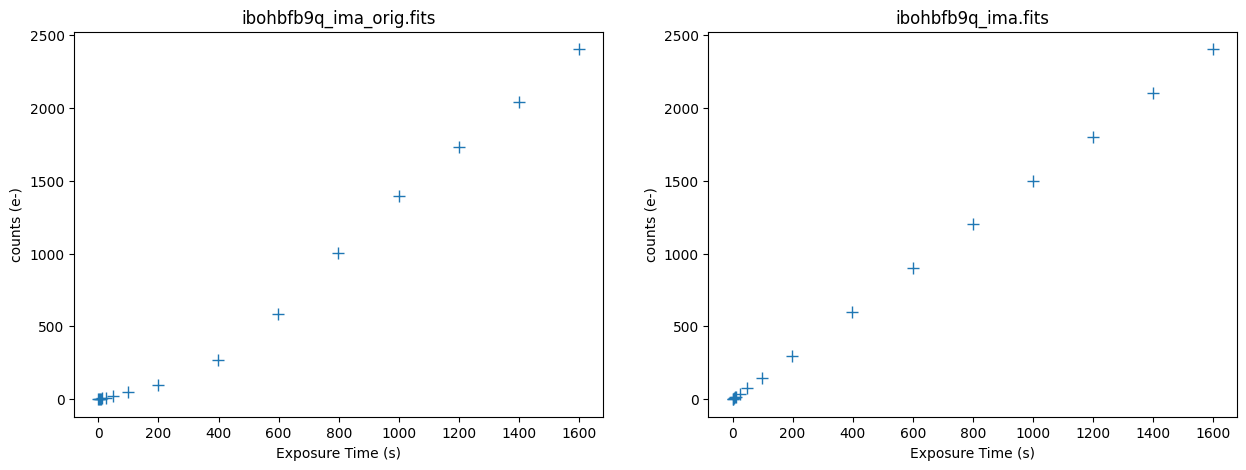

In [15]:
imafiles = ('ibohbfb9q_ima_orig.fits', 'ibohbfb9q_ima.fits')
ylim = [(0.3, 0.7), (0.3, 1.8)]
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
fig.set_dpi(100)

for i, ima in enumerate(imafiles):
    time, counts = wfc3tools.pstat(ima, stat='midpt', units='counts', plot=False)
    axarr[i].plot(time, counts, '+', markersize=8)
    axarr[i].set_title(ima)
    axarr[i].set_xlabel('Exposure Time (s)')
    axarr[i].set_ylabel('counts (e-)')

Here we plot the  median count rate versus time for the original and corrected ramp. We see the corrected image now has a flat median count rate.

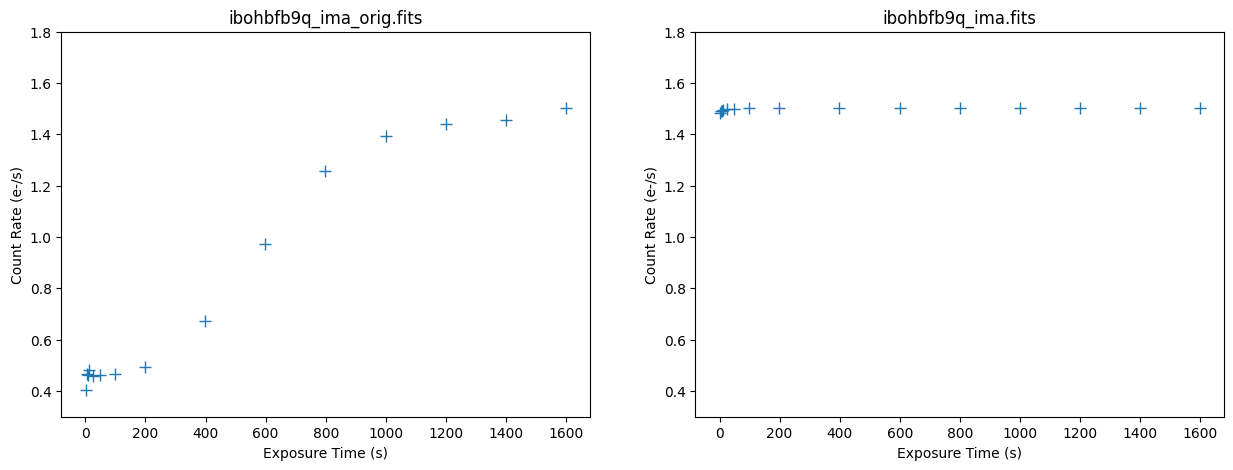

In [16]:
imafiles = ('ibohbfb9q_ima_orig.fits', 'ibohbfb9q_ima.fits')
ylim = [(0.3, 1.8), (0.3, 1.8)]
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))
fig.set_dpi(100)

for i, ima in enumerate(imafiles):
    time, counts = wfc3tools.pstat(ima, stat='midpt', units='rate', plot=False)
    axarr[i].plot(time, counts, '+', markersize=8)
    axarr[i].set_title(ima)
    axarr[i].set_xlabel('Exposure Time (s)')
    axarr[i].set_ylabel('Count Rate (e-/s)')
    axarr[i].set_ylim(ylim[i])

### 5.4 Comparing the Background Noise <a id="5.4"></a>
Below we compute the mean, median, and standard deviation (electrons/sec) of the different FLT data products.

In [17]:
w = np.where((0. < flt1f) & (flt1f < 1.))
flt1_mean = np.mean(flt1f[w])
flt1_med = np.median(flt1f[w])
flt1_std = np.std(flt1f[w])

w = np.where((1. < flt2f) & (flt2f < 2.))
flt2_mean = np.mean(flt2f[w])
flt2_med = np.median(flt2f[w])
flt2_std = np.std(flt2f[w])

w = np.where((1. < flt2fcorr) & (flt2fcorr < 2.))
flt2f_mean = np.mean(flt2fcorr[w])
flt2f_med = np.median(flt2fcorr[w])
flt2f_std = np.std(flt2fcorr[w])

ramp = ['Linear Bkg', 'Time Variable Bkg', 'Corrected Bkg']
filename = ['ibohbfb7q_flt', 'ibohbfb9q_flt_orig.fits', 'ibohbfb9q_flt.fits']
mean = [flt1_mean, flt2_mean, flt2f_mean]
med = [flt1_med, flt2_med, flt2f_med]
std = [flt1_std, flt2_std, flt2f_std]

Table = {
    "RAMP": ramp,
    "Filename": filename,
    "Mean": mean,
    "Median": med,
    "Stdev": std,
}
df = pd.DataFrame(Table)
df

,RAMP,Filename,Mean,Median,Stdev
0,Linear Bkg,ibohbfb7q_flt,0.469859,0.466303,0.037946
1,Time Variable Bkg,ibohbfb9q_flt_orig.fits,1.539043,1.623629,0.169443
2,Corrected Bkg,ibohbfb9q_flt.fits,1.504395,1.501570,0.045748


Here we can see that the corrected background of the affected FLT file has a standard deviation that improved by a factor of ~4. This corrected standard deviation is also more agreeable with the standard deviation of the linear background of the unaffected image *ibohbfb7q*.

### 5.5 Morphology <a id="5.5"></a>
The improved FLT products can be useful for studies on faint, extended sources.
Here, we plot 25"x25" cutouts of the original and corrected FLT data product. The corrected FLT product no longer shows a bimodal distribution in the pixel values (due to poor ramp fit) and therefore appears less noisy. The reprocessed image will now produce more accurate photometry and have reduced systematic errors.

Text(0.5, 1.0, 'ibohbfb9q (Corrected Bkg)')

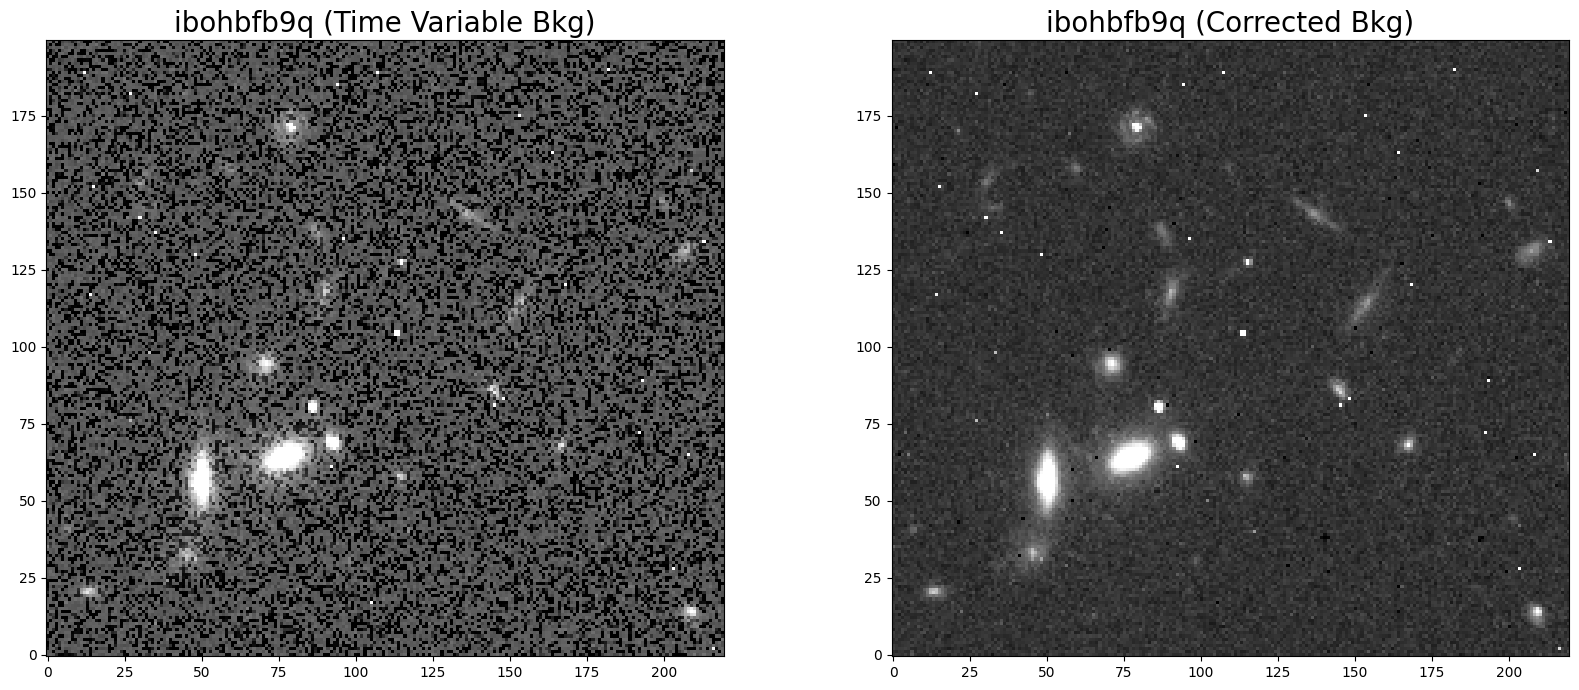

In [18]:
# Display the images
flt2 = fits.getdata('ibohbfb9q_flt_orig.fits', ext=1)
flt2corr = fits.getdata('ibohbfb9q_flt.fits', ext=1)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(flt2[520:720, 750:970], vmin=1.3, vmax=2.5, cmap='Greys_r', origin='lower')
ax2.imshow(flt2corr[520:720, 750:970], vmin=1.3, vmax=2.5, cmap='Greys_r', origin='lower')

ax1.set_title('ibohbfb9q (Time Variable Bkg)', fontsize=20)
ax2.set_title('ibohbfb9q (Corrected Bkg)', fontsize=20)

## 6. Conclusion <a id="conclusions"></a>

Thank you for walking through this notebook. When working with WFC3/IR data, you should be more familiar with:
- Identifying IR exposures with time variable background.
- Compute and analyze statistics on IMA files.
- Reprocess a single exposure without cosmic ray corrections through `calwfc3`.
- Correct for spatially uniform time variable background by flattening IR ramps.

#### **Congratulations! You have completed the notebook!**

## Additional Resources <a id="add"></a>
Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see section 7.10 for more information on time-variable background.
- [WFC3 IR Photometric Calibration Page](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/ir-photometric-calibration)
- [WFC3 ISR 2016-16](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-16.pdf)


## About this Notebook <a id="about"></a>

**Author:** Ky Huynh, Jennifer Mack, WFC3 Instrument Team

**Published On:** 2023-05-25 <br>
**Updated On:** 2023-11-21

## Citations <a id="cite"></a>

If you use `numpy`, `astropy`, `astroquery`, or `wfc3tools` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)

<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 